### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import kaggle
import cv2

plt.style.use('seaborn')
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Q1

#### 1. Data Preparation

In [9]:
def extract_frames(video_path, output_folder, duration=30):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file")
        return
    

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    
    end_frame = min(int(duration * frame_rate), total_frames)
    
    for frame_num in tqdm(range(end_frame)):
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(output_folder, f"frame_{frame_num}.jpg"), frame)

    cap.release()
    
video_path = "./data/forest_gump.mp4"
output_folder = "/scratch/fk/forest_gump"

extract_frames(video_path, output_folder, duration=30)


  0%|          | 0/690 [00:00<?, ?it/s]

#### 2. Face Detection

In [24]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
IMG_PATH = '/scratch/fk/forest_gump/'
img_files = os.listdir(IMG_PATH)
img_indices = np.argsort([int(i.split('_')[1].split('.')[0]) for i in img_files])
img_files = np.array(img_files)[img_indices]
img_files.shape

(690,)

  0%|          | 0/690 [00:00<?, ?it/s]

()


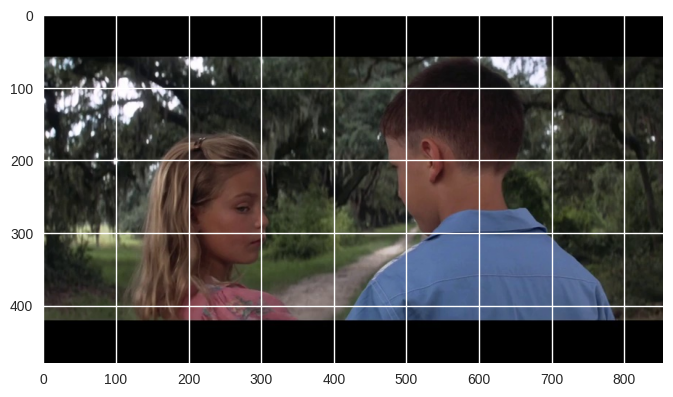

()


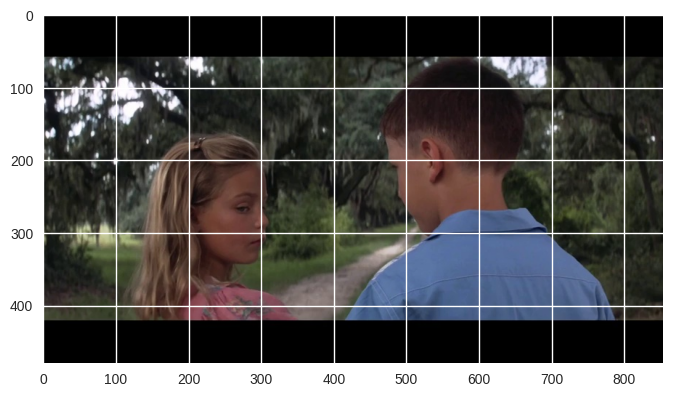

()


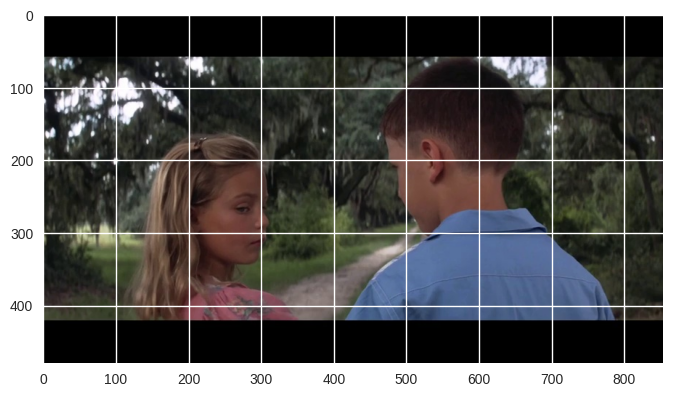

()


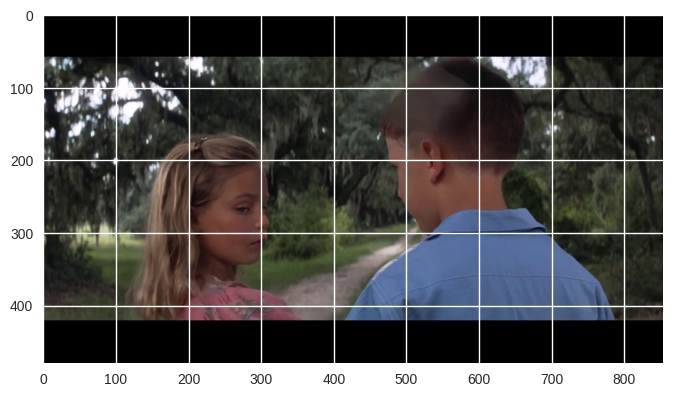

()


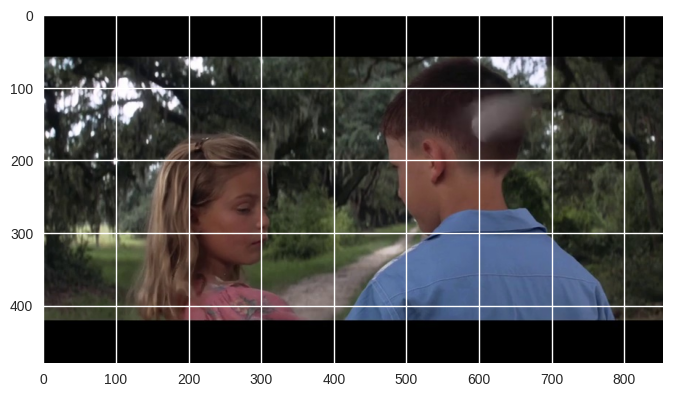

()


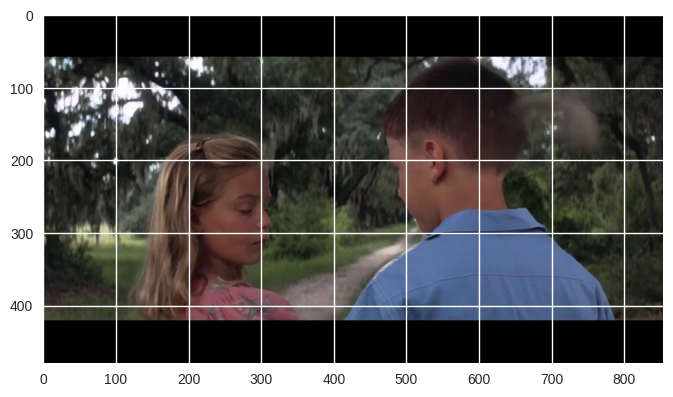

()


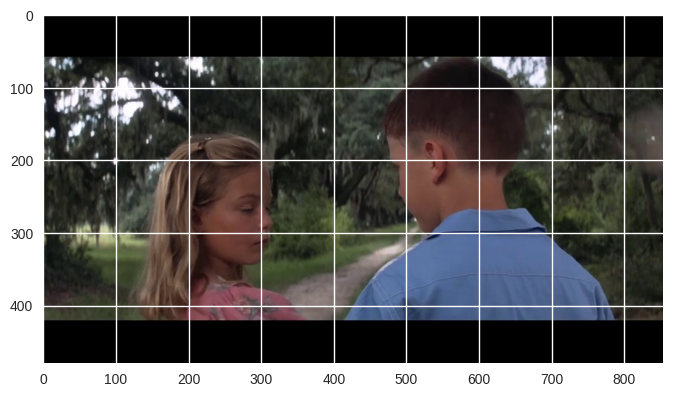

()


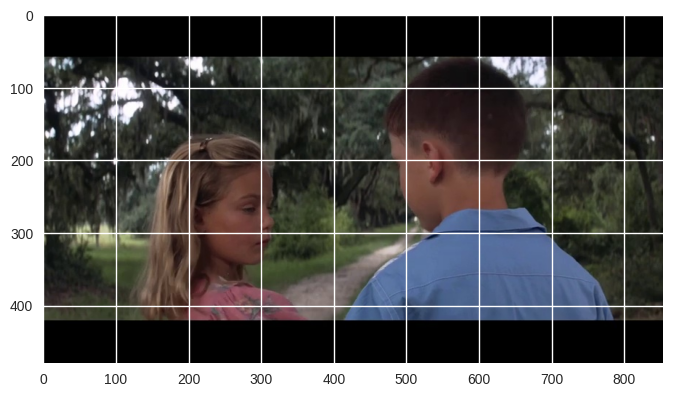

()


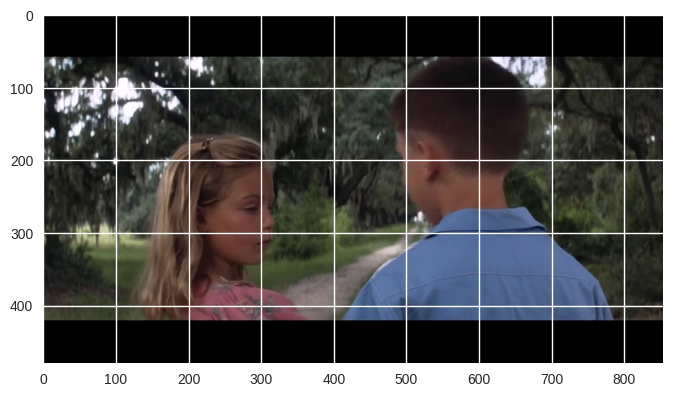

()


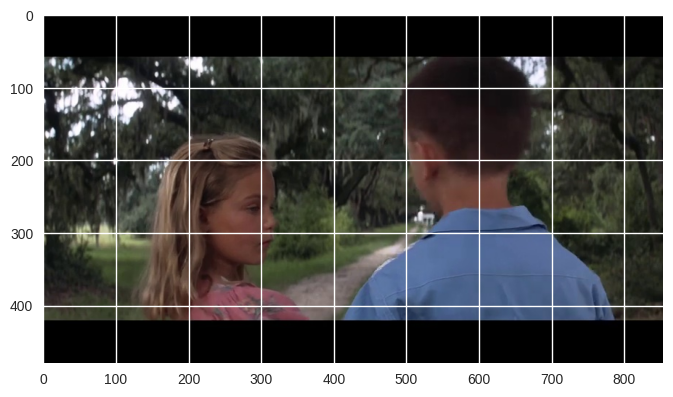

()


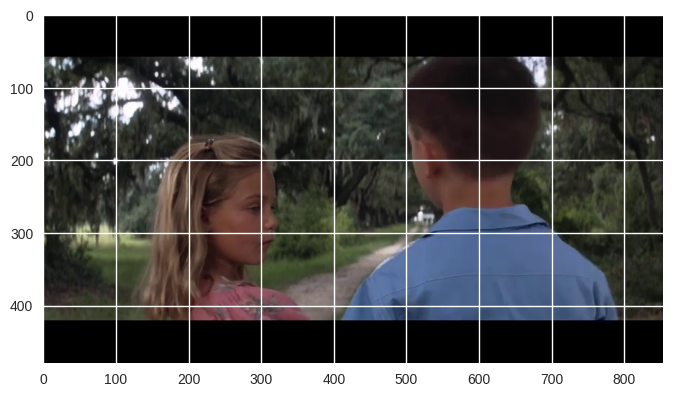

()


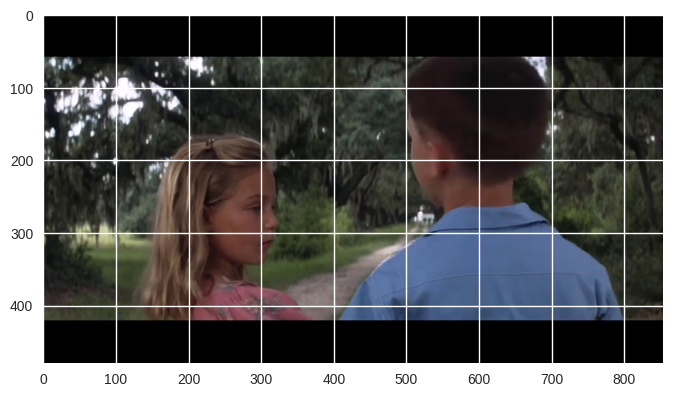

()


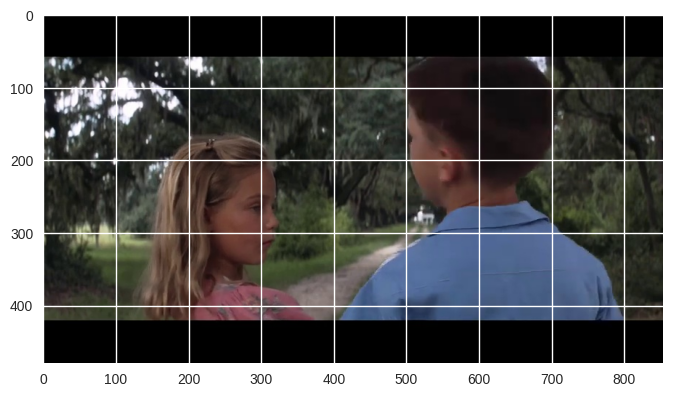

()


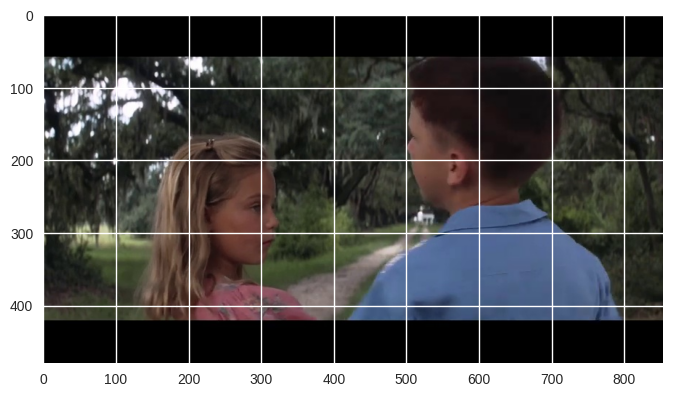

()


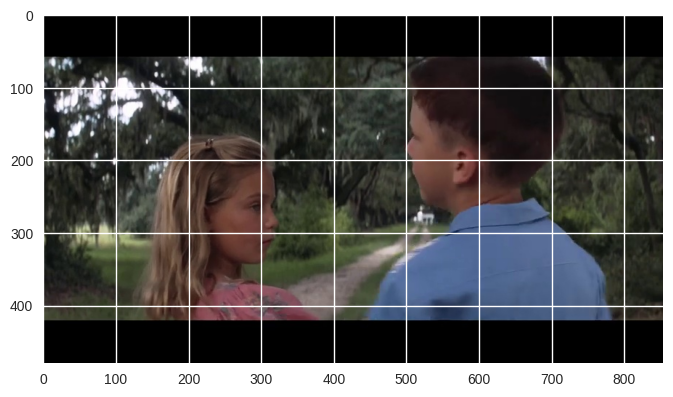

()


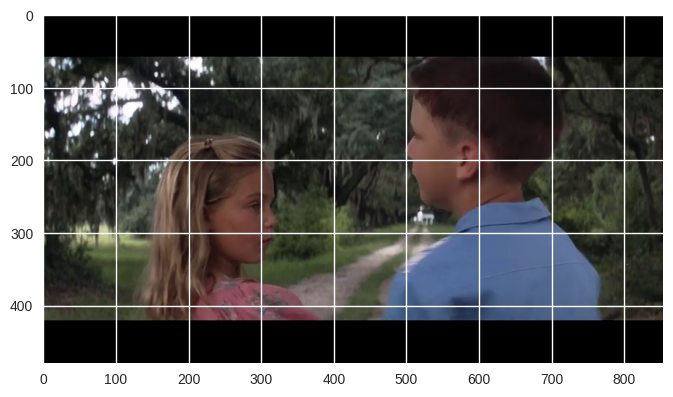

()


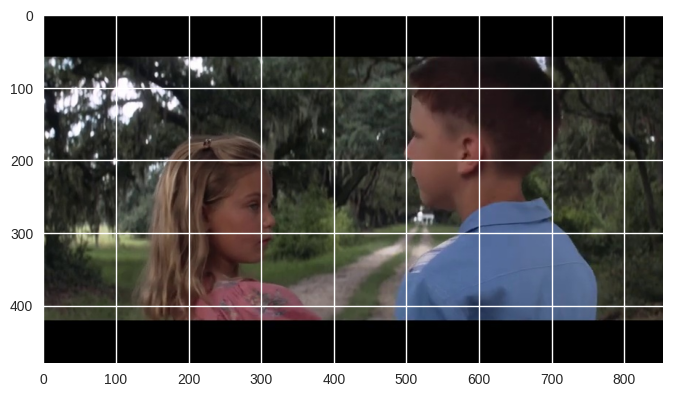

()


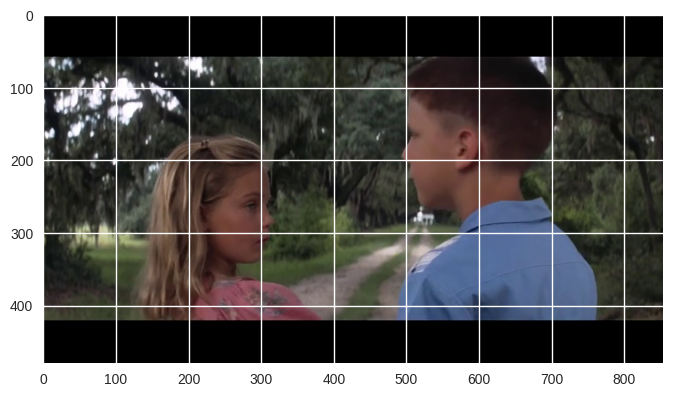

()


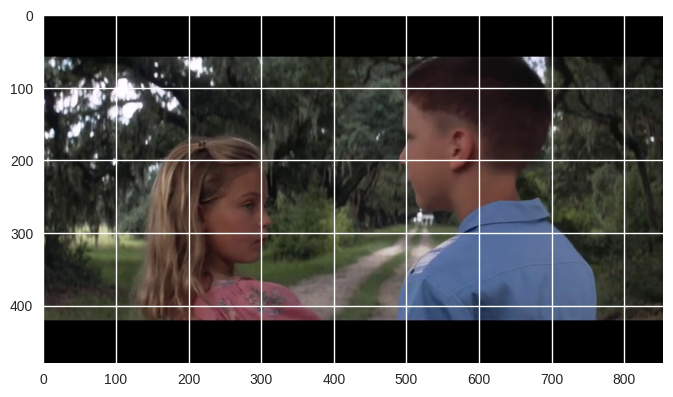

()


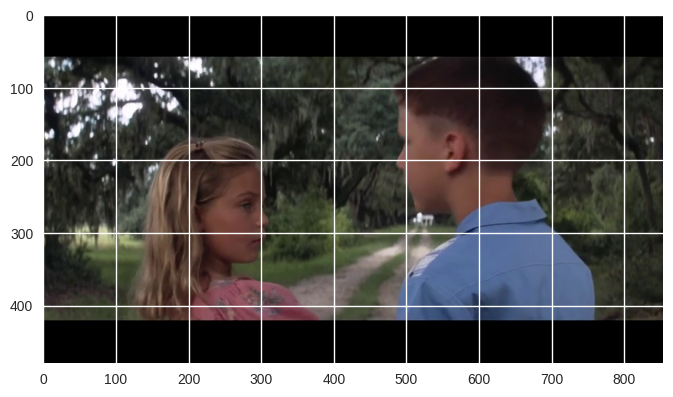

()


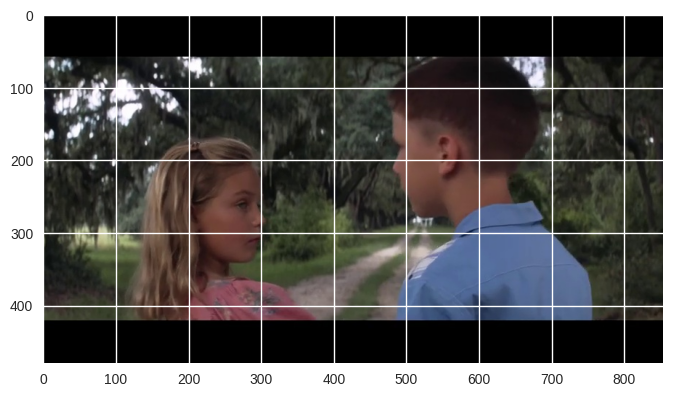

()


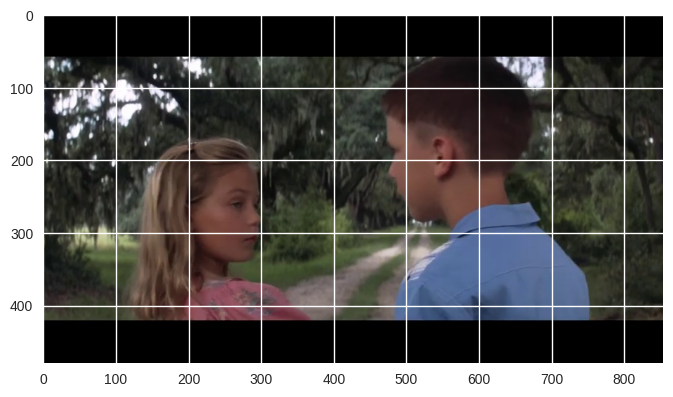

()


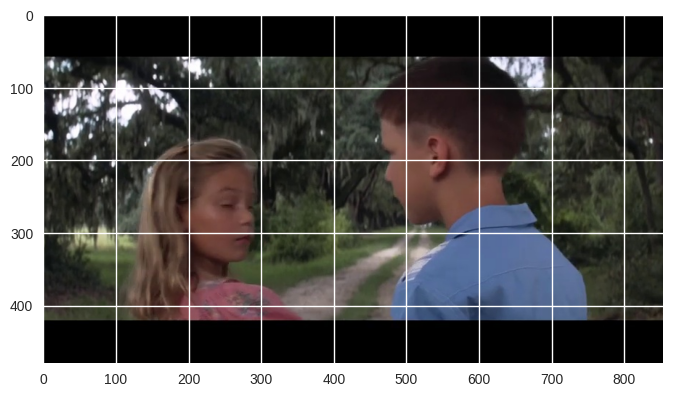

()


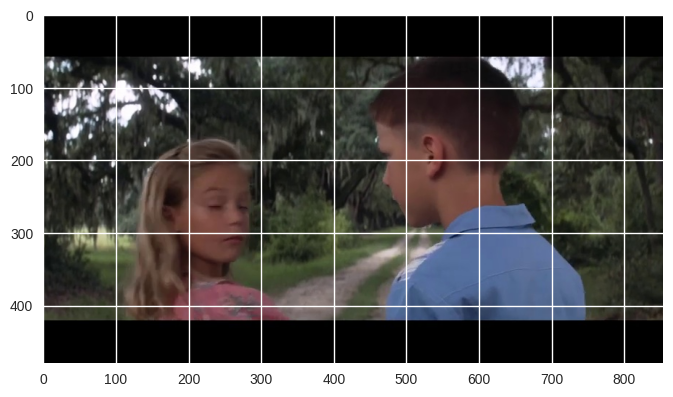

[[181 217 122 122]]


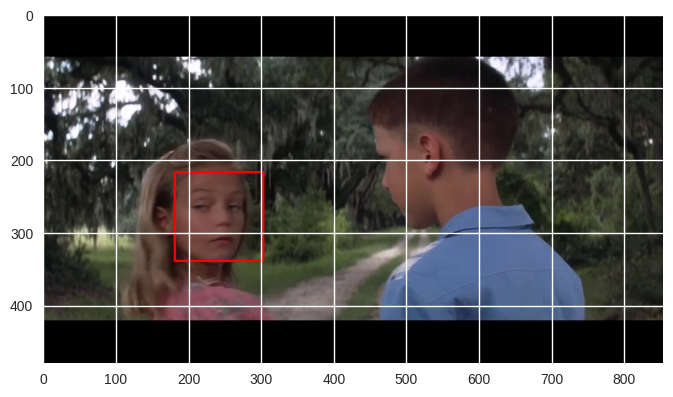

[[169 218 122 122]]


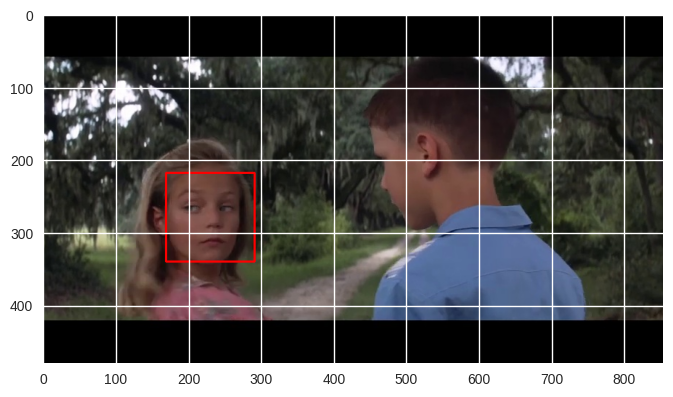

[[164 218 122 122]]


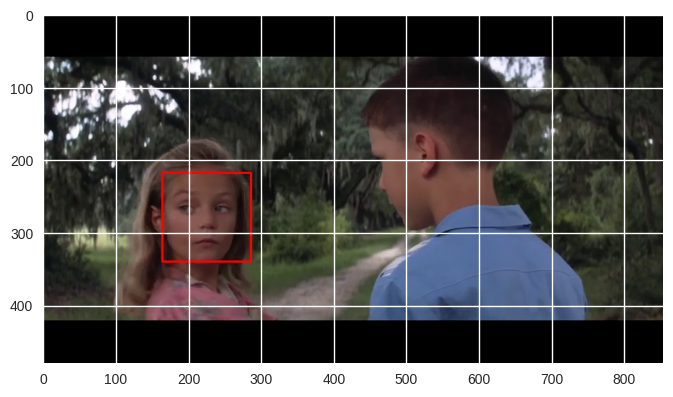

[[160 219 122 122]]


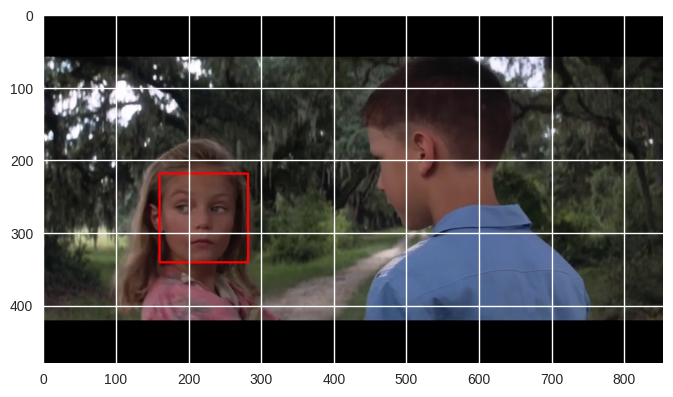

[[154 219 122 122]]


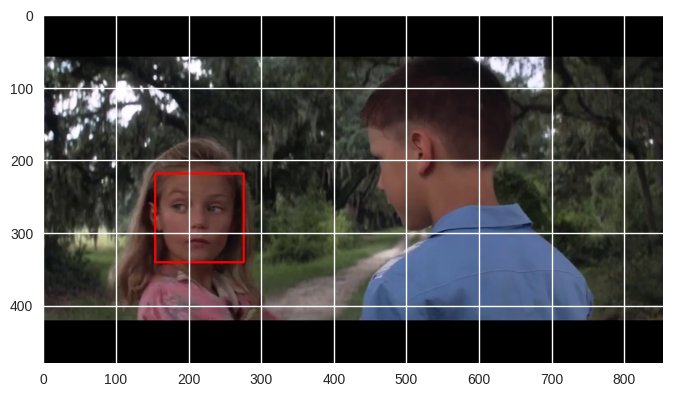

[[149 218 122 122]]


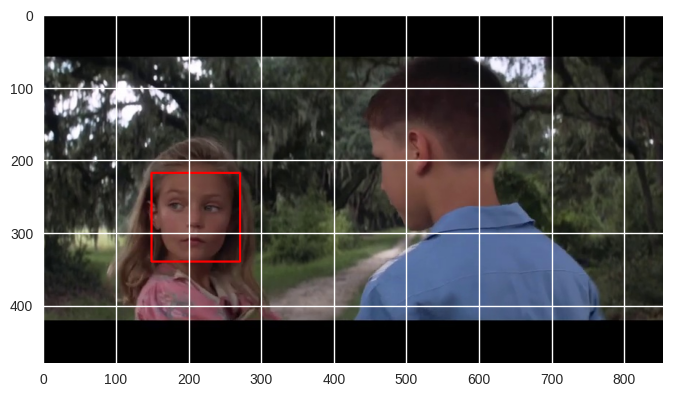

In [89]:
face_detections = []

for i, img in tqdm(enumerate(img_files[:10]), total=len(img_files)):
    img = cv2.imread(os.path.join(IMG_PATH, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    print(faces)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
    plt.imshow(img)
    plt.show()
    # plt.imsave(img, f'./outputs/forest_gump_faces/{i}.jpg')
        

In [60]:
def images_to_video(images, output_video_path, fps=20):

    first_image = images[0]
    height, width, _ = first_image.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for img in tqdm(images):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        out.write(img)

    out.release()
    
output_video_path = "./outputs/forest_gump_face.mp4"
images_to_video(face_detections, output_video_path)

  0%|          | 0/690 [00:00<?, ?it/s]

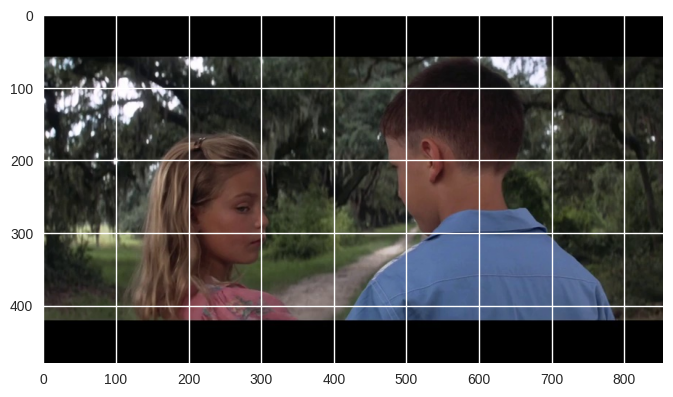

In [64]:
plt.imshow(face_detections[0])

## Q2

### 1. Data Preparation

In [6]:
!kaggle datasets download -d haziqasajid5122/yolov8-finetuning-dataset-ducks -p /scratch/fk/ --unzip

100%|███████████████████████████████████████▉| 491M/492M [00:27<00:00, 20.3MB/s]
100%|████████████████████████████████████████| 492M/492M [00:27<00:00, 18.8MB/s]


### 2. Understanding YOLO models

<img src='https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/63c697965a86db36ab528b16_YOLO%20timeline-min.jpg' width='30%'>

Single-shot detectors like YOLO (You Only Look Once) differ from the R-CNN (Region-based Convolutional Neural Network) series primarily in their approach to object detection.

In R-CNN, the image is first processed to generate region proposals, which are then fed into a convolutional neural network (CNN) for feature extraction and classification. This multi-step process can be computationally expensive and time-consuming. Whereas, YOLO takes a single-pass approach. It divides the image into a grid and predicts bounding boxes and class probabilities for objects directly from this grid. This results in faster inference times compared to R-CNN, as YOLO only requires a single forward pass through the network.

Different versions of YOLO:

1. **YOLOv3**: YOLOv3 introduces several improvements over its predecessors, including the use of feature pyramid networks (FPNs) to extract features at multiple scales, which improves detection accuracy for objects of different sizes. It also incorporates additional techniques such as spatially-aware darknet, which enhances the network's ability to localize objects accurately.

2. **YOLOv4**: YOLOv4 further improves upon YOLOv3 by introducing various architectural changes and optimization techniques. It incorporates features such as CSPDarknet53 as the backbone network, which improves feature extraction efficiency, and the use of multi-scale prediction heads for detecting objects at different scales more effectively. Additionally, YOLOv4 incorporates various training techniques like data augmentation and regularization to improve model generalization and robustness.

3. **YOLOv5**: YOLOv5 is a recent version that introduces a simpler and more efficient architecture compared to previous versions. It utilizes a lightweight backbone network based on EfficientNet and focuses on model scaling and optimization to achieve high performance on various platforms. YOLOv5 also introduces the concept of ensemble methods, where multiple YOLO models of different sizes are combined to improve detection accuracy further.


### 3. Hands on with ultralytics library

In [ ]:
# !pip install ultralytics

In [16]:
from ultralytics import settings

settings.update({'runs_dir': '/scratch/fk/runs'})
settings.update({'datasets_dir': '/scratch/fk/datasets'})
settings.update({'weights_dir': '/scratch/fk/weights'})

print(settings)

{'settings_version': '0.0.4', 'datasets_dir': '/scratch/fk/datasets', 'weights_dir': '/scratch/fk/weights', 'runs_dir': '/scratch/fk/runs', 'uuid': 'e696c75e3c76056947386ecd811405137e6c97abac6177aeda1d55691cba8b42', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}


In [37]:
from ultralytics import YOLO

model_8n = YOLO('yolov8n.yaml').to(device)


In [49]:
def get_num_parameters(model):
    counter = 0
    for param in model.parameters():
        counter += param.numel()
        
    print(f"Number of parameters: {counter:,}")

def get_num_conv_layers(model):
    counter = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            counter +=1
    print(f"Number of conv layers: {counter}")
    
get_num_parameters(model_8n)
get_num_conv_layers(model_8n)


Number of parameters: 3,157,200
Number of conv layers: 64


In [52]:
model_8m = YOLO('yolov8m.yaml').to(device)
get_num_parameters(model_8m)
get_num_conv_layers(model_8m)


Number of parameters: 25,902,640
Number of conv layers: 84


| Model         | # parameters  | # conv layers |
|----------     |---------------|---------------|
| yolo-v8-nano  | 3,157,200     | 64            |
| yolo-v8-medium| 25,902,640    | 84            |

From the above table, we can see that yolo-v8-medium has about 8 times more parameters than yolo-v8-nano and about 1.3 times more number of conv layers.

In [57]:
import fiftyone

Migrating database to v0.23.7


In [79]:
fiftyone.zoo.download_zoo_dataset(
              "open-images-v7",
              dataset_dir='/scratch/fk/',
              splits=["train", 'validation'],
              label_types=["detections"],
              classes=["Duck"],
          )

 100% |██████|    4.8Gb/4.8Gb [34.7s elapsed, 0s remaining, 130.8Mb/s]      


: 

: 